#ANLP Assignment 2 - Automated Text Classification
##Author - Jack Burgemeister (A1773773)

### Objective - Develop a centralised knowledge hub for those interested in developing skills in the field of Natural Language Processing (NLP) through collection and visualisation of Stack Overflow articles.

###Notebook Structure
1. Data Collection
2. Pre-Processing
3. Graphical Representation
4. Data Categorisation

In [ ]:
# Libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import warnings
from tqdm import tqdm
from more_itertools import chunked
import re
import string
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import openai
import spacy
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')  # Stopwords
stop_words = set(stopwords.words('english')) #Stopwords Dictionary
nlp = spacy.load("en_core_web_sm") # Tokeniser Library
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!pip install --upgrade openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.0/647.0 kB 14.4 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.72.0
    Uninstalling openai-1.72.0:
      Successfully uninstalled openai-1.72.0


#Section 1: Data Collection
1. Stack Overflow API Download
2. Data Visualisation

##1.1: Stack Overview API Download

In [ ]:
# API Search Parameters
api_key = "insert_api_key"
tag = "nlp"
site = "stackoverflow"
sort = "creation"
order = "asc"
page_size = 100

In [ ]:
# Questions Retrieval
questions = list()

# Start + End Date
start_date = datetime.datetime(2000, 1, 1)
end_date = datetime.datetime(2025, 4, 5)

# Convert to Unix Timestamp (Used by StackExchange API)
start_timestamp = int(start_date.timestamp())
end_timestamp = int(end_date.timestamp())

# Date Range Step Size
step_days = 30

# Main Loop
while (start_timestamp < end_timestamp) and (len(questions) < 25000):
  next_timestamp = start_timestamp + step_days * 24 * 60 * 60

  page = 1
  while True:
    questions_url = f"https://api.stackexchange.com/2.3/questions?page={page}&pagesize={page_size}&order={order}&sort={sort}&tagged={tag}&filter=withbody&site={site}&key={api_key}&fromdate={start_timestamp}&todate={next_timestamp}"

    questions_reponse = requests.get(questions_url)
    questions_data = questions_reponse.json()

    if "items" in questions_data:
      questions.extend(questions_data["items"])

    if not questions_data.get("has_more", False):
      break

    page += 1
    time.sleep(0.2)

  start_timestamp = next_timestamp

print(f"Total questions retrieved: {len(questions)}")

Total questions retrieved: 20081


In [ ]:
# Assembly of Initial Data Frame
df = pd.DataFrame([{
    "question_id": q["question_id"],
    "title": q["title"],
    "tags": q["tags"],
    "view_count": q["view_count"],
    "creation_date": datetime.datetime.utcfromtimestamp(q["creation_date"]),
    "body": q["body"]
} for q in questions])

In [ ]:
# Collection of Answers
answers_dict = {}

# Call all IDs in Batches of 100 until all IDs Called
for batch_ids in tqdm(list(chunked(df["question_id"], 100)), desc="Fetching Answers"):
    page = 1
    while True:
        ids_str = ';'.join(map(str, batch_ids))
        answers_url = (
            f"https://api.stackexchange.com/2.3/questions/{ids_str}/answers"
            f"?page={page}&pagesize=100&site={site}&filter=withbody&key={api_key}"
        )

        try:
            response = requests.get(answers_url)
            data = response.json()

            for item in data.get("items", []):
                qid = item["question_id"]
                answers_dict.setdefault(qid, []).append(item["body"])

            # Backoff Flag to Limit API Calls
            if "backoff" in data:
                time.sleep(data["backoff"])
            else:
                time.sleep(0.2)

            if not data.get("has_more", False):
                break

            page += 1

        except Exception as e:
            print(f"Error fetching answers for batch: {ids_str}")
            print(e)
            break

# Map Answers to Questions
df["answers"] = df["question_id"].apply(lambda qid: answers_dict.get(qid, ["No Answer"])[0])

Fetching Answers: 100%|██████████| 201/201 [02:37<00:00,  1.28it/s]


In [ ]:
# Re-Format Dataset w/ Appropriate Columns and Headers
final_df = df[["title","tags","body","view_count","creation_date","answers"]].copy()
final_df = final_df.rename(columns={"title":"Title","tags":"Tags","body":"Question Body","view_count":"Views","creation_date":"Creation Date","answers":"Answer Body"})

##1.2: Data Visualisation
1. Answered vs Un-Answered Questions
2. Distribution of Questions over Time
3. Distribution of Views over Time
4. Distribution of Posts per Tag over Time

###1.2.1: Answered vs. Un-Answered

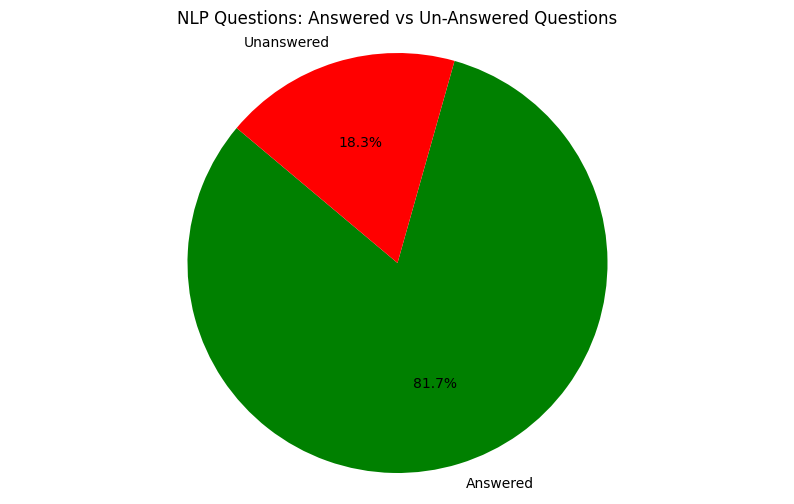

In [ ]:
# Count Frequency
answer_counts = final_df["Answer Body"].apply(lambda x: x != "No Answer").value_counts()
labels = ["Answered", "Unanswered"]
sizes = [answer_counts[True], answer_counts[False]]

# Plot Pie
plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140, colors=["green","red"])
plt.title("NLP Questions: Answered vs Un-Answered Questions")
plt.axis("equal")
plt.show()

###1.2.2: Distribution of Questions over Time

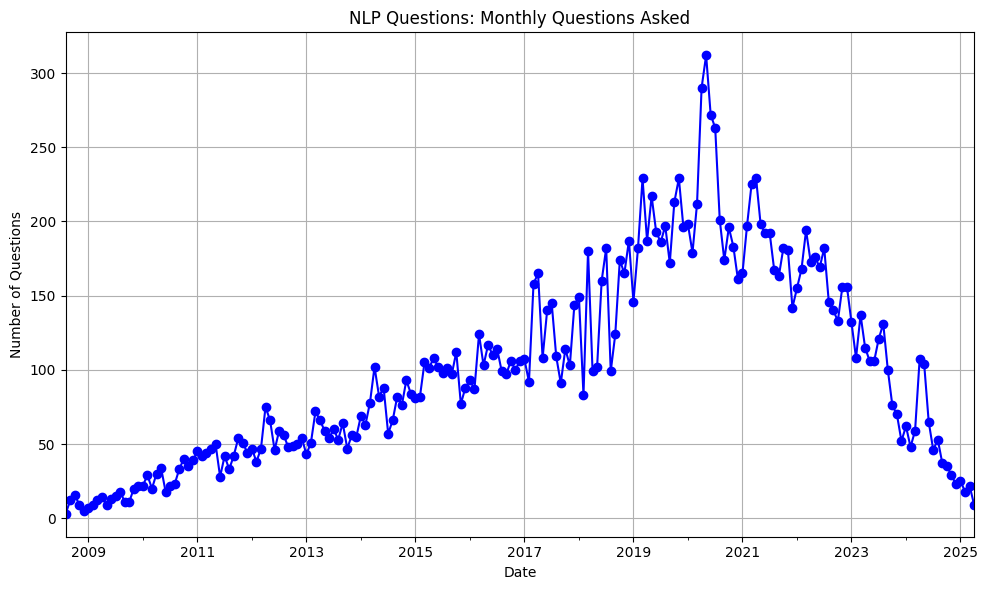

In [ ]:
# Group Creation Date by Month
monthly_counts = final_df.resample("M", on="Creation Date").size()

# Plot Line
plt.figure(figsize=(10, 6))
monthly_counts.plot(kind="line", marker="o", color="blue")
plt.title("NLP Questions: Monthly Questions Asked")
plt.xlabel("Date")
plt.ylabel("Number of Questions")
plt.grid(True)
plt.tight_layout()
plt.show()

###1.2.3: Distribution of Views over Time

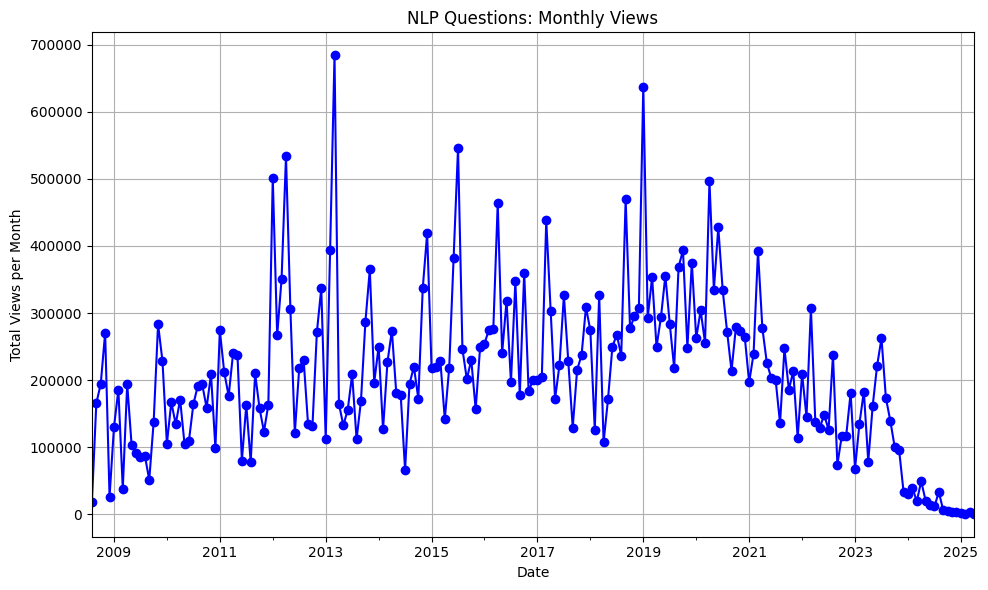

In [ ]:
# Group by Monthly Views (Sum)
monthly_views = final_df.resample("M", on="Creation Date")["Views"].sum()

# Plot Line
plt.figure(figsize=(10, 6))
monthly_views.plot(kind="line", color="blue", marker="o")
plt.title("NLP Questions: Monthly Views")
plt.xlabel("Date")
plt.ylabel("Total Views per Month")
plt.grid(True)
plt.tight_layout()
plt.show()

###1.2.4: Distribution of Posts per Tag over Time

<Figure size 1000x600 with 0 Axes>

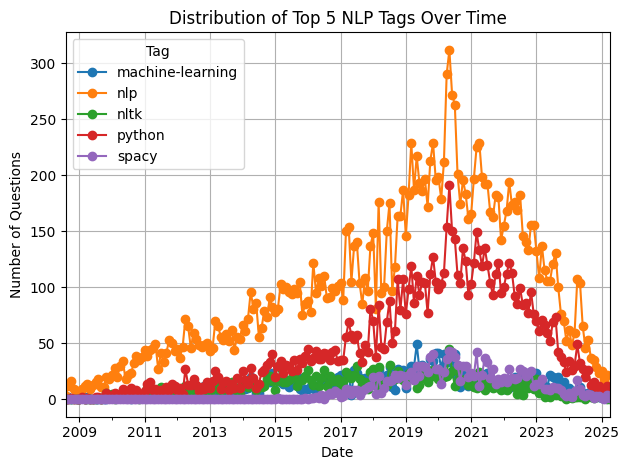

In [ ]:
# Extract Tags into Seperate DF
tags_df = final_df[["Creation Date", "Tags"]].explode("Tags").copy()

# Count Top 5 Tags
top_tags = tags_df["Tags"].value_counts().nlargest(5).index

# Filter for Top 5 Tags
filtered_tags_df = tags_df[tags_df["Tags"].isin(top_tags)]

# Grop by Month and Tag
tag_time = filtered_tags_df.groupby([pd.Grouper(key="Creation Date", freq="M"), "Tags"]).size().unstack(fill_value=0)

# Plot Line
plt.figure(figsize=(10, 6))
tag_time.plot(kind="line", marker='o')
plt.title("Distribution of Top 5 NLP Tags Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Questions")
plt.legend(title="Tag")
plt.grid(True)
plt.tight_layout()
plt.show()

#Section 2: Pre-Processing
**Functions**:
1. Remove Punctuation
2. Lowercase
3. Tokenisation
4. Stop-Words  
**Application to Dataset**:  
5. Pre-Process Dataset

In [ ]:
# Removing Questions with No Accepted Answer
final_df = final_df[final_df["Answer Body"] != "No Answer"]

##2.1: Remove Punctuation

In [ ]:
def remove_punctuation(text: str) -> str:
  """
  Input: A textual string || Output: The string with punctuation removed
  """
  if isinstance(text, str):
    return re.sub(r'[^\s\w]','',text)
  return text

##2.2: Lowercase

In [ ]:
def lowercase(text: str) -> list:
  """
  Input: A textual string || Output: The string in lowercase
  """
  if isinstance(text, str):
    return text.lower()
  return text

##2.3: Tokenisation

In [ ]:
def tokeniser(text: str) -> str:
  """
  Input: A textual string || Output: A list of tokens
  """
  if isinstance(text, str):
    return [token.text for token in nlp(text)]
  return []

##2.4: Stop-Words

In [ ]:
def remove_stopwords(tokens: list) -> list:
  """
  Input: List of Tokens || Output: List of Tokens with Stopwords Removed
  """
  if isinstance(tokens, list):
    return [token for token in tokens if not nlp.vocab[token].is_stop]
  return []

##2.5: Pre-Process Dataset

In [ ]:
def preprocess_pipeline(text: str) -> list:
  """
  Input: A textual string || Output: A pre-processed list of tokens corresponding to the original string
  """
  return remove_stopwords(tokeniser(remove_punctuation(lowercase(text))))

In [ ]:
pre_processed_data = final_df.copy()

pre_processed_data["Title Tokenised"] = pre_processed_data["Title"].apply(preprocess_pipeline)
pre_processed_data["Question Body Tokenised"] = pre_processed_data["Question Body"].apply(preprocess_pipeline)
pre_processed_data["Answer Body Tokenised"] = pre_processed_data["Answer Body"].apply(preprocess_pipeline)

#Section 3: Graphical Representation
1. Word Cloud

##3.1: Word Cloud

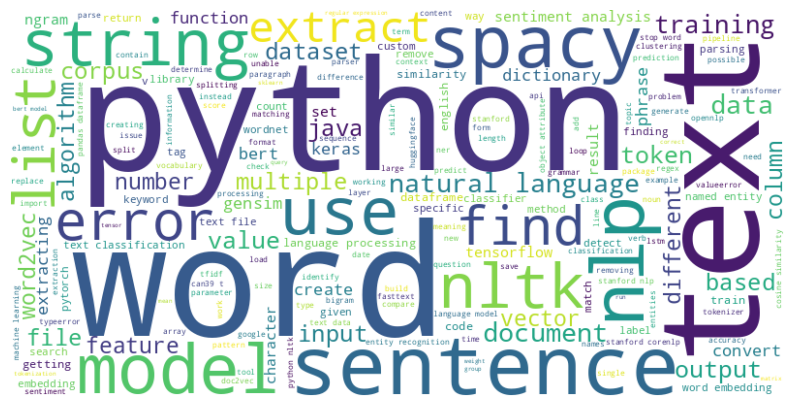

In [ ]:
# Combine Title Lists
combined_titles = " ".join(pre_processed_data["Title Tokenised"].apply(lambda x: ' '.join(x)))

# Generate Wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_titles)

# Plot Wordcloud
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#Section 4: Data Categorisation

1. **Rules-Based**  
  a. Category Definitions.  
  b. Category Assignment.  
  c. Category Visualisation.  
2. **Unsupervised Clustering**  
  a.  Clustering with KMeans.  
  b. Generating Category Labels with OpenAI.  
  c. Category Visualisation.  

In [ ]:
# Copy Dataset
categorised_data = pre_processed_data.copy()

In [ ]:
# Sample Questions per Category
def sample_questions_per_category(df: pd.DataFrame, num_samples: int = 3, mode: int = 0) -> pd.DataFrame:
  """
  Input: Source Dataframe, number of samples per question, and mode (0 = rules-based, 1 = clustering) || Output: DataFrame with num_samples samples per question
  """

  if mode == 0:
    category_slice = 'Categories'
    df = df.explode(category_slice)
  else:
    category_slice = 'Cluster Label'

  df = df[[category_slice, "Title"]]

  sample_df = df.groupby(category_slice).apply(lambda x: x.sample(min(len(x), 3), random_state=42)).reset_index(drop=True)

  return sample_df

##4.1: Rules-Based

###4.1.1: Category Definitions

In [ ]:
categories = {
    "Implementation": ["how to", "how can", "config"],
    "Text Similarity": ["similarity", "compare", "matching"],
    "Tokenisation": ["tokenize", "punctuation", "split"],
    "Pre-Processing Techniques": ["lowercase", "stopwords", "stemming", "lemmetisation"],
    "Language Identification": ["language defect", "identity language", "language detection", "language classifier", "langid","langdetect"],
    "Libraries": ["spacy", "nltk", "hugging face", "gensim", "word2vec", "fasttext", "lda", "pytorch", "tensorflow", "keras", "sklearn"],
    "Basic Knowledge": ["what", "explain", "meaning"]
}

###4.1.2: Category Assignment

In [ ]:
def categorize_post(title_tokens: list, accepted_answer_tokens: list = []) -> list:
    """
    Input: A list of tokens representing the title of a question, and corresponding list of tokens representing the accepted answer || Output: A list of categories the post belongs to.
    """

    # Combine Title and Accepted Answer Tokens
    tokens = title_tokens + accepted_answer_tokens
    matched_categories = []

    # If Title/Answer Token Matches Keyword, Assign the Question to the Associated Category
    for category, keywords in categories.items():
        for keyword in keywords:
            keyword_tokens = keyword.lower().split()
            if all(kw_token in tokens for kw_token in keyword_tokens):
                matched_categories.append(category)
                break

    # If no Match, Assign "Other"
    if not matched_categories:
        matched_categories.append("Other")

    return matched_categories

In [ ]:
# Categorise Questions
categorised_data["Categories"] = categorised_data.apply(lambda row: categorize_post(row["Title Tokenised"], row["Answer Body Tokenised"]), axis=1)

###4.1.3: Category Visualisation

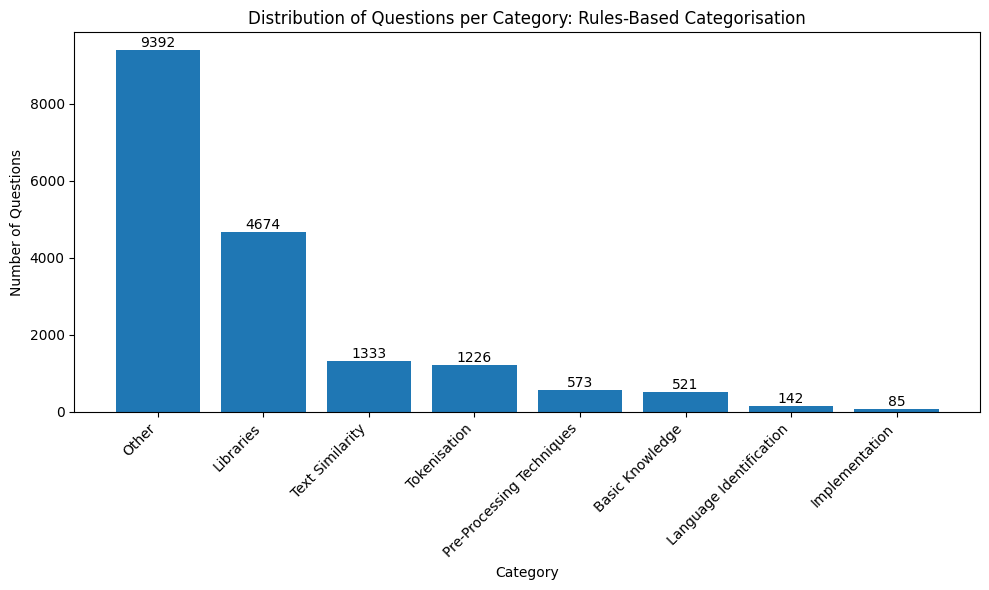

In [ ]:
# Collect Categories and Frequency
categories = [category for sub_list in categorised_data["Categories"] for category in sub_list]
category_freq = pd.Series(categories).value_counts()

# Create Matplotlib Figure and Plot Bars
plt.figure(figsize=(10, 6))
bars = plt.bar(category_freq.index, category_freq.values)

# Add Data Labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.1, int(yval), ha='center', va='bottom')

# Plot Accessories
plt.title("Distribution of Questions per Category: Rules-Based Categorisation")
plt.xlabel("Category")
plt.ylabel("Number of Questions")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
categorised_data.head()

,Title,Tags,Question Body,Views,Creation Date,Answer Body,Title Tokenised,Question Body Tokenised,Answer Body Tokenised,Categories,Cluster,Cluster Label
0,Natural language date/time parser for .NET?,"[.net, datetime, nlp]",<p>Does anyone know of a .NET date/time parser...,6488,2008-08-22 22:45:10,<p>A .NET port of Chronic exists. See <a href=...,"[natural, language, datetime, parser, net]","[pdoes, know, net, datetime, parser, similar, ...","[pa, net, port, chronic, exists, hrefhttpsgith...",[Other],2,Machine learning model
1,What&#39;s a good natural language library to ...,"[language-agnostic, nlp]",<p>I'm looking for an existing library to summ...,6492,2008-08-24 20:57:33,<p>There was some discussion of Grok. This is...,"[what39s, good, natural, language, library, us...","[pim, looking, existing, library, summarize, p...","[pthere, discussion, grok, , supported, openc...",[Basic Knowledge],2,Machine learning model
2,Vista speech recognition in multiple languages,"[windows-vista, nlp, speech-recognition, multi...","<p>my primary language is spanish, but I use a...",5661,2008-08-31 01:08:48,<p>You should look at System.Speech.Recognitio...,"[vista, speech, recognition, multiple, languages]","[pmy, primary, language, spanish, use, softwar...","[pyou, look, systemspeechrecognitionspeechreco...",[Other],3,Word embeddings
3,How do you implement a &quot;Did you mean&quot;?,[nlp],<blockquote>\n <p><strong>Possible Duplicate:...,33222,2008-09-03 10:36:13,<p>Google's Dr Norvig has outlined how it work...,"[implement, quotdid, meanquot]","[blockquote, \n , pstrongpossible, duplicates...","[pgoogles, dr, norvig, outlined, works, gives,...",[Other],3,Word embeddings
4,How to implement a &quot;related&quot; degree ...,"[algorithm, machine-learning, indexing, nlp, f...",<p>I was going to Ask a Question earlier today...,456,2008-09-03 20:21:04,"<p><a href=""https://stackoverflow.com/question...","[implement, quotrelatedquot, degree, measure, ...","[pi, going, ask, question, earlier, today, pre...","[pa, hrefhttpsstackoverflowcomquestions42489ho...",[Other],3,Word embeddings


In [ ]:
# Sample Questions for Categories
sample_questions_rules = sample_questions_per_category(categorised_data, mode = 0)
print(sample_questions_rules.to_markdown(index = False))

| Categories                | Title                                                                                                                 |
|:--------------------------|:----------------------------------------------------------------------------------------------------------------------|
| Basic Knowledge           | How to extract paragraphs from pdf?                                                                                   |
| Basic Knowledge           | python NLTK POS tagger not behaving as expected                                                                       |
| Basic Knowledge           | Parsing Meaning from Text                                                                                             |
| Implementation            | How to convert a AutoModelForCausalLM object to a dspy model object?                                                  |
| Implementation            | How to config nltk data directory from code?                          

##4.2: Unsupervised Clustering

###4.2.1 Clustering with K-Means

In [ ]:
# Collect Text
text = categorised_data["Title Tokenised"].tolist()
text = [" ".join(tokens) for tokens in text]

# Convert Text to TF-IDF Vectors
vectorizer = TfidfVectorizer(stop_words = "english")
X = vectorizer.fit_transform(text)

# Apply K-Means
k = 6
km_model = KMeans(n_clusters = k, random_state = 42)
km_model.fit(X)

# Add Cluster Labels
categorised_data["Cluster"] = km_model.labels_

###4.2.2: Generating Cluster Labels

In [ ]:
# Instantiate OpenAI Client
client = openai.OpenAI(api_key = "insert_api_key")

def make_prompt(terms, existing_labels = []):
  """
  Input: Top Terms, Existing Labels || Output: Prompt for API Call
  """
  existing_labels_str = ', '.join(existing_labels)

  return f"Given the following keywords: {', '.join(terms)}, suggest a concise label (1-3 words) that best describe the common theme. Avoid suggesting labels similar to the following already generated labels: {existing_labels_str}"

def call_api(terms, existing_labels):
  """
  Input: Top Terms, Existing Labels || Output: API Response
  """
  prompt = make_prompt(terms, existing_labels)

  response = client.chat.completions.create(
      model = "gpt-3.5-turbo",
      messages=[{"role": "user","content":prompt}],
      temperature = 0.3
  )

  return response.choices[0].message.content.strip()

def get_cluster_labels(cluster_top_terms):
  """
  Input: Top Terms from each Cluster || Output: Cluster Labels for each Cluster
  """
  final_labels = []

  for terms in cluster_top_terms:
    label = call_api(terms, final_labels)
    final_labels.append(label)

  return final_labels

In [ ]:
# Extract Top Terms for each Cluster
cluster_top_terms = list()
for i in range(k):
  cluster_terms = list(vectorizer.get_feature_names_out()[km_model.cluster_centers_[i].argsort()[-10:]])
  cluster_top_terms.append(cluster_terms)

# Use LLM to derive Unique Labels
cluster_labels = get_cluster_labels(cluster_top_terms)

In [ ]:
# Writing Labels to DF
cluster_label_dict = {i: label.capitalize() for i, label in enumerate(cluster_labels)}
categorised_data["Cluster Label"] = categorised_data["Cluster"].map(cluster_label_dict)

###4.2.3: Category Visualisation

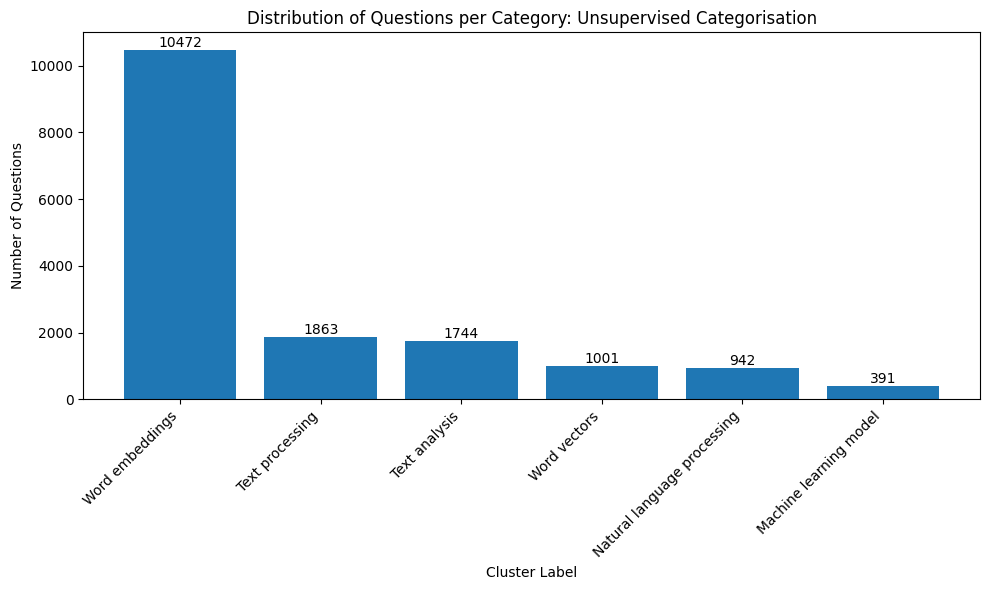

In [ ]:
# Collect Cluster Labels and Frequency
cluster_label_freq = categorised_data['Cluster Label'].value_counts()

# Create Matplotlib Figure and Plot Bars
plt.figure(figsize=(10, 6))
bars = plt.bar(cluster_label_freq.index, cluster_label_freq.values)

# Add Data Labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.1, int(yval), ha='center', va='bottom')

# Plot Accessories
plt.title("Distribution of Questions per Category: Unsupervised Categorisation")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Questions")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
# Sample Questions for Categories
sample_questions_cluster = sample_questions_per_category(categorised_data, mode = 1)
print(sample_questions_cluster.to_markdown(index = False))

| Cluster Label               | Title                                                                                             |
|:----------------------------|:--------------------------------------------------------------------------------------------------|
| Machine learning model      | What programming language is most like natural language?                                          |
| Machine learning model      | String chunking algorithm with natural language context                                           |
| Machine learning model      | Natural Language Parsing tools: what is out there and what is not?                                |
| Natural language processing | SpaCy: Do I need to perform early stopping while training the model for custom entities?          |
| Natural language processing | spaCy Tokenizer LEMMA and ORTH Exceptions Not Working                                             |
| Natural language processing | Python import spacy sentence bert           

In [ ]:
categorised_data.to_csv("anlp_a2_final_dataset.csv")